<a href="https://colab.research.google.com/github/aai510-group1/project/blob/main/Final%20Project%20Section3-Team%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title { display-mode: "form" }
# @markdown <br/>
# @markdown <center><h1>Customer Churn Prediction with AutoML</h1></center>
# @markdown <br/>
# @markdown <center><h1>The University of San Diego</h1></center>
# @markdown <br/>
# @markdown <center><h3>Jonathan Agustin</h3></center>
# @markdown <center><h3>Dina Shalaby</h3></center>
# @markdown <center><h3>Paul Parks</h3></center>
# @markdown <br/>
# @markdown <center>
# @markdown <table>
# @markdown   <tr>
# @markdown     <td><a href="https://github.com/aai510-group1/project"><img src="https://raw.githubusercontent.com/aai510-group1/project/main/assets/github-logo.png" alt="GitHub" width="50" height="50"></a></td>
# @markdown     <td><a href="https://github.com/aai510-group1/project"><h3>aai510-group1/project</h3></a></td>
# @markdown   </tr>
# @markdown </table>
# @markdown </center>

## <b>Problem Statement and Justification</b>

<center><b><h3>This project aims to develop a predictive model to identify high-risk churn customers for Telco, addressing the significant financial and reputational impacts of customer churn by enabling proactive retention strategies.</h3></b></center>

Customer churn, the rate at which customers discontinue their relationship with a company, presents a significant challenge for businesses across industries, particularly for telecommunications companies like Telco. The financial implications of customer churn are substantial, as acquiring new customers is significantly more expensive than retaining existing ones. A high churn rate necessitates continuous investment in marketing and sales efforts, putting pressure on Telco's profitability. Each customer lost translates to lost revenue, increased marketing expenditures, and potential harm to brand reputation.

Moreover, customer churn can negatively impact Telco's brand image. When customers leave, it signals dissatisfaction with Telco's services, potentially deterring new customers and attracting unfavorable media attention.

Therefore, addressing customer churn is paramount for Telco to maintain profitability, preserve its market standing, and ensure long-term success. Developing a reliable churn prediction model empowers Telco to take proactive measures, engage at-risk customers, and implement targeted retention strategies, ultimately mitigating churn and fostering stronger customer relationships.


In [14]:
%%bash
apt-get install -qqq --no-install-recommends graphviz libgraphviz-dev

# USE uv FOR FASTER PIP INSTALLS
pip install --quiet --progress-bar=off uv

# INSTALL DEPENDENCIES
uv pip uninstall --system --quiet bokeh mkl

uv pip install --system --quiet --upgrade pip

uv pip install --system --quiet --upgrade \
    black[jupyter] \
    bokeh \
    datasets \
    isort \
    pygraphviz \
    setuptools \
    wheel

uv pip install --system --quiet autogluon numpy==1.24.4 shap

In [3]:
# @title Create a Folder in Google Drive and Enable Top-Level Access in the File Browser { display-mode: "form" }
def setup_drive_folder(google_drive_folder):
    import contextlib, google.colab, os, pathlib
    if not google_drive_folder:
        google_drive_folder = "temp"
    with contextlib.redirect_stdout(open(os.devnull, 'w')):
        google.colab.drive.mount("/content/drive", force_remount=True)
    drive_path = pathlib.Path("/content/drive/MyDrive")
    colab_notebooks_path = drive_path / "Colab Notebooks"
    project_path = colab_notebooks_path / google_drive_folder
    project_path.mkdir(parents=True, exist_ok=True)
    shortcut = pathlib.Path(f"/content/{google_drive_folder}")
    shortcut.parent.mkdir(parents=True, exist_ok=True)
    if not shortcut.exists():
        shortcut.symlink_to(project_path)
    print(f"SHORTCUT: {shortcut} --> {project_path}")
    return str(shortcut)

google_drive_folder = "aai510-group1"  # @param { type: "string" }
SHORTCUT = setup_drive_folder(google_drive_folder)

SHORTCUT: /content/aai510-group1 --> /content/drive/MyDrive/Colab Notebooks/aai510-group1


In [5]:
# DATA VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns

# NUMERICAL OPERATIONS
import numpy as np

# PREPROCESSING
from sklearn.preprocessing import LabelEncoder, StandardScaler

# MODEL SELECTION AND EVALUATION
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score
)

# MACHINE LEARNING MODELS
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# DEEP LEARNING
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

## <b>Dataset</b>

<center><b><h3>The Telco Customer Churn dataset, comprising 7,043 customers and 53 features, provides a comprehensive view of customer demographics, service usage, and churn status, serving as the foundation for this project.</h3></b></center>

The Telco Customer Churn dataset serves as the foundation for this project. It encompasses data on 7,043 customers subscribed to phone and internet services. The dataset comprises 53 features, offering a comprehensive view of each customer's demographics, service usage, and churn status. These features include:

- **Demographics.** Age, gender, partner status, dependents status.
- **Service Usage.** Internet service type, phone service, multiple lines, online security, online backup, device protection, tech support, streaming TV, streaming movies, contract type, paperless billing, payment method, monthly charges, total charges.
- **Customer Status.** Tenure, churn status, satisfaction score.


In [7]:
# DATA MANIPULATION AND ANALYSIS
import pandas as pd

# LOAD MERGED TELCO CUSTOMER DATASET
from datasets import load_dataset
dataset = load_dataset('aai510-group1/telco-customer-churn', token=False)

# CONVERT DATASETS TO PANDAS DATAFRAMES
df_train = dataset['train'].to_pandas()
df_test = dataset['test'].to_pandas()
df_val = dataset['validation'].to_pandas()

df = pd.concat([df_train, df_test, df_val], ignore_index=True)

In [13]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 52 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                7043 non-null   int64  
 1   Avg Monthly GB Download            7043 non-null   int64  
 2   Avg Monthly Long Distance Charges  7043 non-null   float64
 3   Churn                              7043 non-null   int64  
 4   Churn Category                     1869 non-null   object 
 5   Churn Reason                       1869 non-null   object 
 6   Churn Score                        7043 non-null   int64  
 7   City                               7043 non-null   object 
 8   CLTV                               7043 non-null   int64  
 9   Contract                           7043 non-null   object 
 10  Country                            7043 non-null   object 
 11  Customer ID                        7043 non-null   objec

## <b>Data Preprocessing</b>

<center><b><h3>Data preprocessing involves removing irrelevant and leakage features, and encoding categorical features to ensure data quality and model compatibility.</h3></b></center>

Before model training, the dataset undergoes preprocessing to ensure data quality and model compatibility. The following steps are taken:

1. **Removal of Irrelevant Features.** Features deemed irrelevant to churn prediction, such as 'Customer ID', 'Country', and 'State', are removed. These features either do not provide predictive value or are constant across the dataset.

2. **Exclusion of Leakage Variables.** Leakage variables, which directly reveal information about churn and can artificially inflate model accuracy, are excluded. These variables include 'Churn Score', 'Churn Reason', 'Churn Category', and 'Customer Status'.

3. **Encoding of Categorical Features.** Categorical features, initially represented as text, are transformed into numerical values using Label Encoding. This conversion ensures compatibility with machine learning algorithms that require numerical input.

### Drop target and leakage variables

In [8]:
# Drop irrelevant columns: 'Customer ID', 'Country', and 'State' as they do not
# contribute to the analysis. Note: 'Country' and 'State' are constant across
# the dataset (all entries are 'US' and 'CA' respectively).
# df.drop(columns=['Customer ID', 'Country', 'State'], inplace=True)

# Drop columns that leak information about the target variable 'Churn':
df.drop(
    columns=[
        'Churn Score',    # Directly indicates the likelihood of churn
        'Churn Reason',   # Provides the reason for churn
        'Churn Category', # Categorizes the type of churn
        'Customer Status' # Indicates whether the customer has churned
    ],
    inplace=True
)

### Encoding

In [9]:
# Identify non-numerical features and convert them to numerical features

# Select non-numerical features
non_numerical_features = df.select_dtypes(
    exclude=['int64', 'float64']
).columns.tolist()

label_encoder = LabelEncoder()

# Perform label encoding on each non-numerical feature
for feature in non_numerical_features:
    df[feature] = label_encoder.fit_transform(df[feature])

# Display the first few rows of the DataFrame after label encoding
print("First 5 rows after label encoding:")
print(df.head())

First 5 rows after label encoding:
   Age  Avg Monthly GB Download  Avg Monthly Long Distance Charges  Churn  \
0   72                        4                              19.44      0   
1   27                       59                              45.62      0   
2   59                        0                              16.07      0   
3   25                       27                               0.00      0   
4   31                       21                              17.22      1   

   City  CLTV  Contract  Country  Customer ID  Dependents  ...  Streaming TV  \
0   873  4849         2        0         3157           0  ...             0   
1   976  3715         0        0         3766           0  ...             1   
2   887  5092         0        0         3887           0  ...             0   
3   109  2068         1        0         1508           0  ...             0   
4   863  4026         1        0          253           0  ...             0   

   Tenure in Months  

## Exploratory Data Analysis (EDA)

This section aims to understand the characteristics of the Telco Customer Churn dataset, uncover relationships between variables, and identify potential predictors of churn. We use both descriptive statistics and visualizations to gain insights from the data.

### Statistical Overview

In [10]:
print("Summary statistics:")
print(df.describe())

Summary statistics:
               Age  Avg Monthly GB Download  \
count  7043.000000              7043.000000   
mean     46.509726                20.515405   
std      16.750352                20.418940   
min      19.000000                 0.000000   
25%      32.000000                 3.000000   
50%      46.000000                17.000000   
75%      60.000000                27.000000   
max      80.000000                85.000000   

       Avg Monthly Long Distance Charges        Churn         City  \
count                        7043.000000  7043.000000  7043.000000   
mean                           22.958954     0.265370   588.042879   
std                            15.448113     0.441561   307.797647   
min                             0.000000     0.000000     0.000000   
25%                             9.210000     0.000000   331.000000   
50%                            22.890000     0.000000   604.000000   
75%                            36.395000     1.000000   854.000000

### Check for missing values

In [11]:
missing_values = df.isnull().sum()
print("\nMissing values:")
print(missing_values)


Missing values:
Age                                  0
Avg Monthly GB Download              0
Avg Monthly Long Distance Charges    0
Churn                                0
City                                 0
CLTV                                 0
Contract                             0
Country                              0
Customer ID                          0
Dependents                           0
Device Protection Plan               0
Gender                               0
Internet Service                     0
Internet Type                        0
Lat Long                             0
Latitude                             0
Longitude                            0
Married                              0
Monthly Charge                       0
Multiple Lines                       0
Number of Dependents                 0
Number of Referrals                  0
Offer                                0
Online Backup                        0
Online Security                      0
Paperles

### Correlation heatmap

The correlation heatmap provides a visual representation of the relationships between features in the dataset. It helps us identify highly correlated features, which might be candidates for feature selection or indicate potential multicollinearity issues.

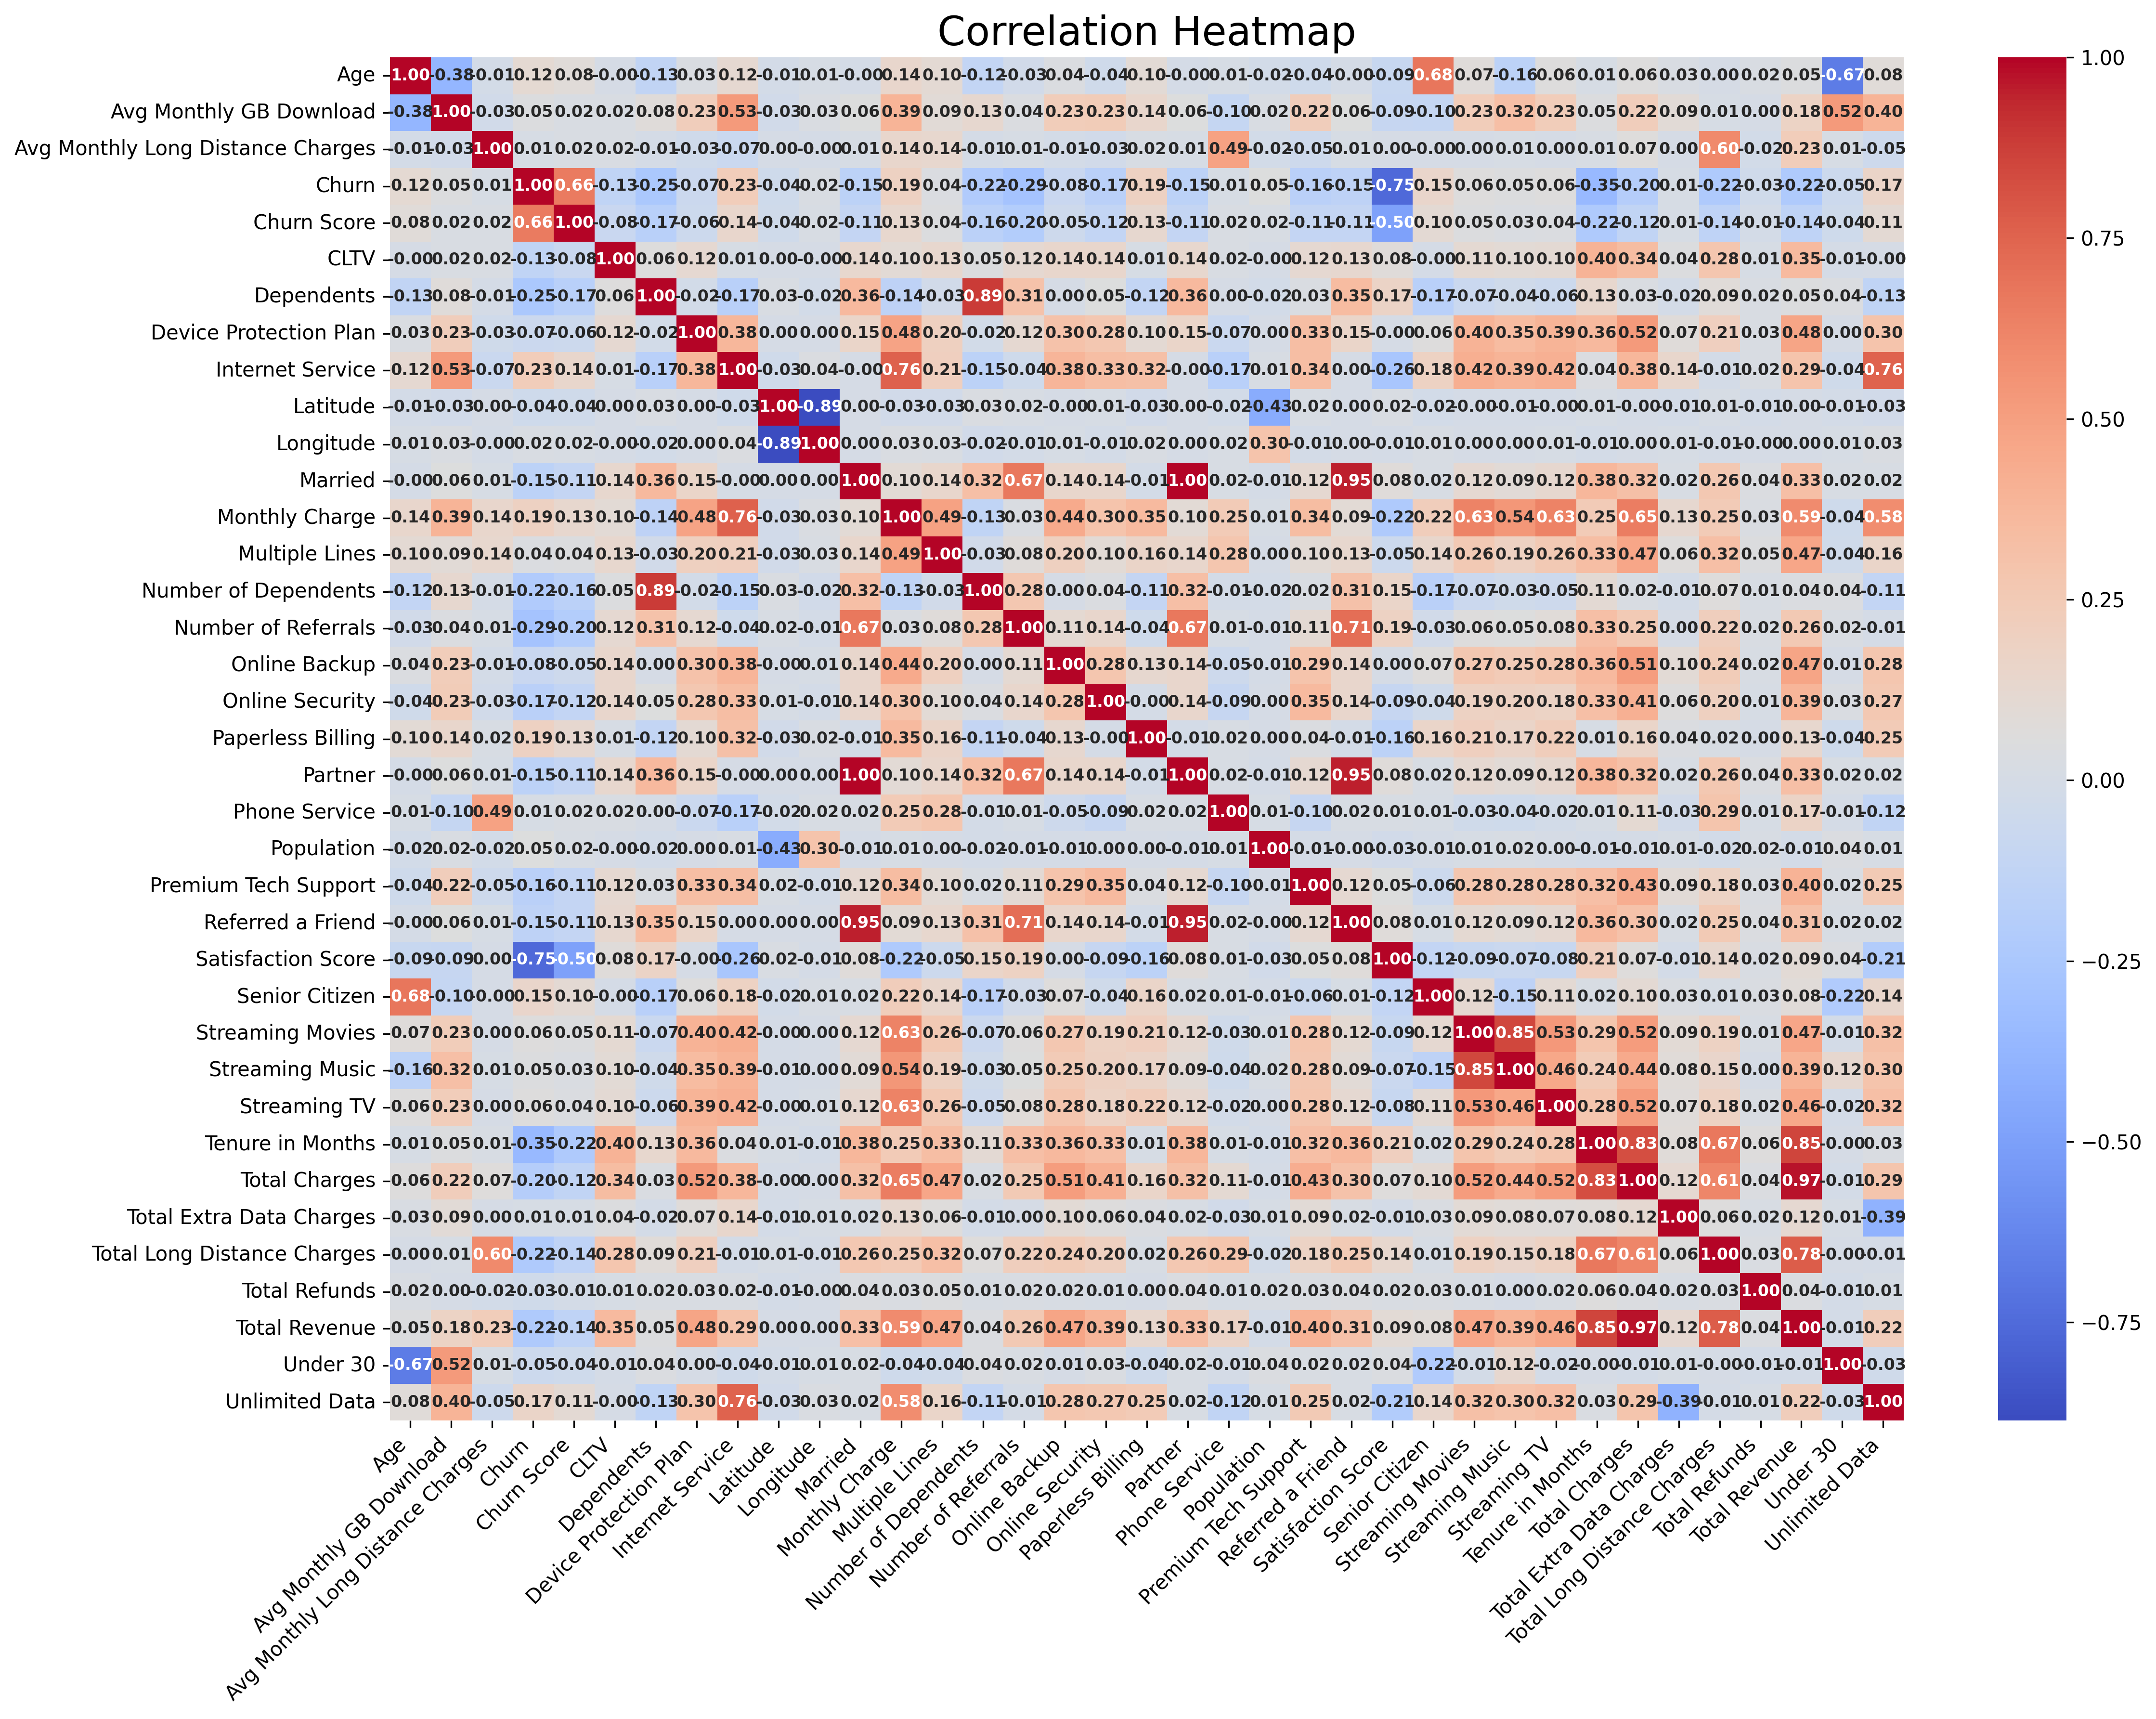

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Filter only numeric columns
numeric_df = df.select_dtypes(include=[float, int])

# Compute the correlation matrix
corr_matrix = numeric_df.corr()

# Create the heatmap with improved aesthetics
plt.figure(
    figsize=(16, 12),
    dpi=300
)

heatmap = sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    annot_kws={"size": 8, "weight": "bold"}
)

# Rotate the x and y axis labels for better readability
heatmap.set_xticklabels(
    heatmap.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize=10
)
heatmap.set_yticklabels(
    heatmap.get_yticklabels(),
    rotation=0,
    fontsize=10
)

# Add a title with a larger font size
plt.title('Correlation Heatmap', fontsize=20)

# Show the plot
plt.tight_layout()
plt.show()

# Distribution of numerical features

Histograms provide a visual overview of the distribution of numerical features, allowing us to observe central tendencies, spread, and potential outliers.


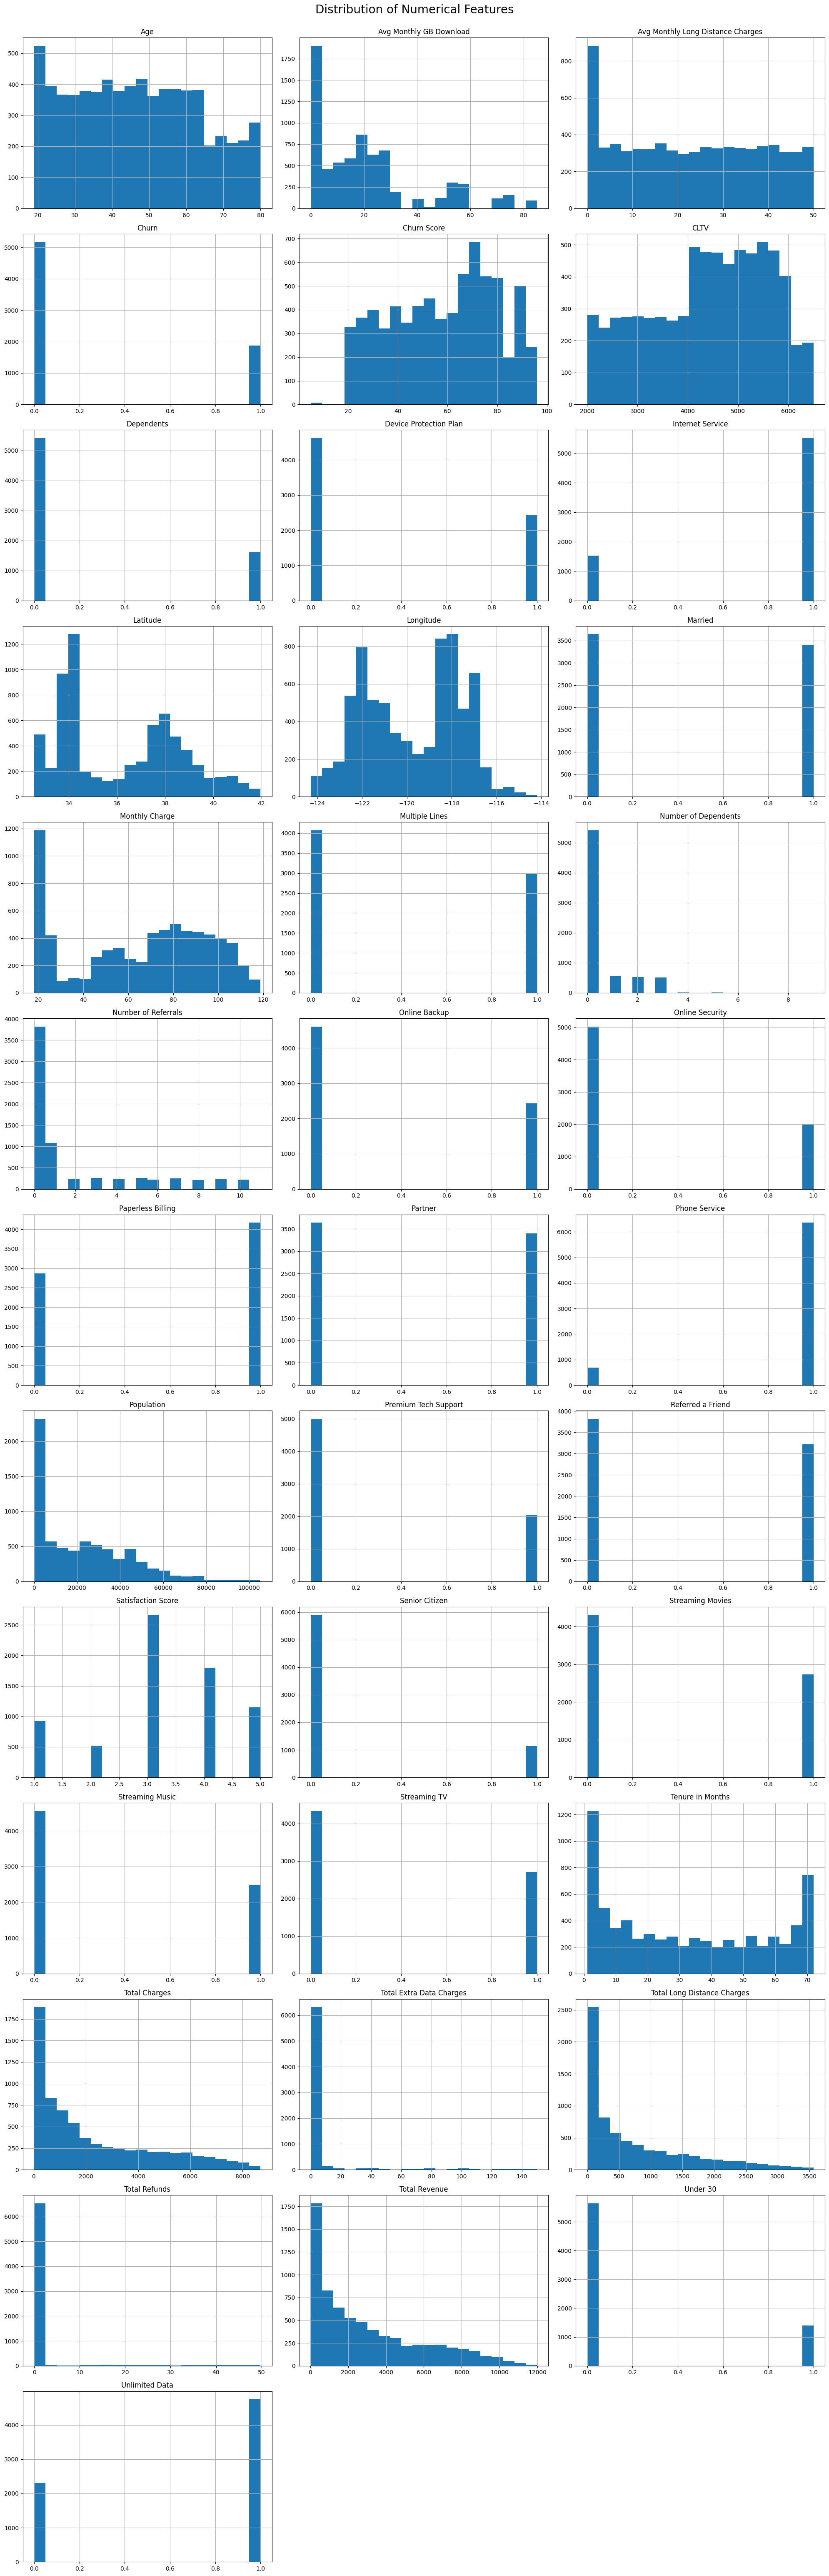

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Select numerical features
numerical_features = df.select_dtypes(
    include=['int64', 'float64']
).columns.tolist()

# Calculate the number of rows needed
n_cols = 3
n_rows = (len(numerical_features) + n_cols - 1) // n_cols

# Create a figure with subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, n_rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot histograms for each numerical feature
for i, feature in enumerate(numerical_features):
    ax = axes[i]
    df[feature].hist(bins=20, ax=ax)
    ax.set_title(feature, fontsize=12)
    ax.set_xlabel('')
    ax.set_ylabel('')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add a main title
plt.suptitle('Distribution of Numerical Features',
             x=0.5,
             y=0.95,
             ha='center',
             fontsize=20)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plot
plt.show()

### In-Depth Feature Analysis

### In-Depth Feature Analysis

We further examine the distributions of key features relevant to churn prediction.

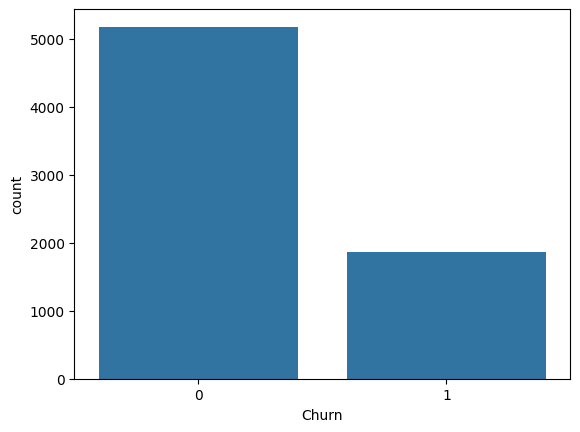

In [14]:
sns.countplot(x='Churn', data=df)
plt.show()

This count plot shows the class imbalance in our target variable, 'Churn'. It helps us understand the proportion of churning customers compared to non-churning customers.

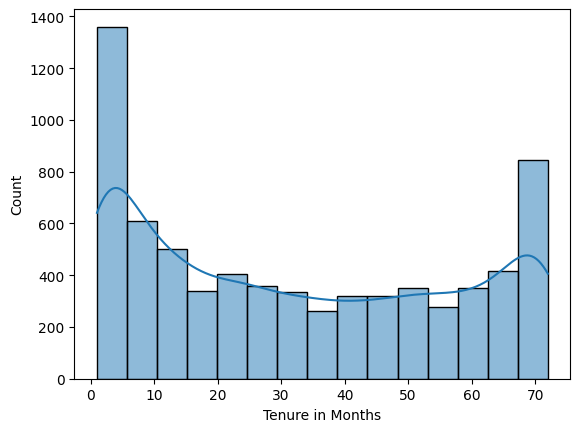

In [15]:
sns.histplot(df['Tenure in Months'], kde=True)
plt.show()

This histogram depicts the distribution of customer tenure, showing how long customers typically stay with Telco.  It helps identify patterns related to churn risk based on tenure.


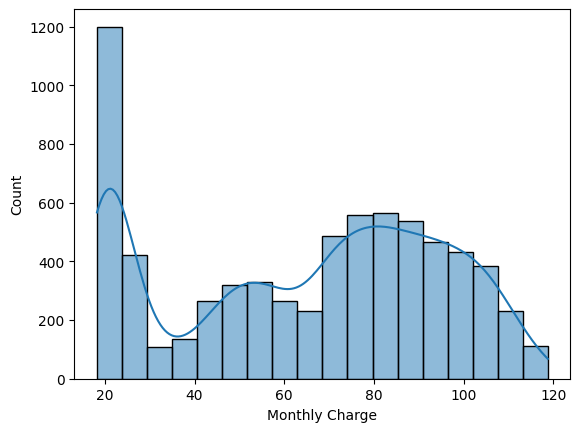

In [16]:
sns.histplot(df['Monthly Charge'], kde=True)
plt.show()

This histogram showcases the distribution of monthly charges.  We can analyze this distribution to see if there are patterns in churn risk related to billing amounts.

## Feature Selection and Engineering

### Feature Correlation with Churn

We perform a correlation analysis to identify features that exhibit the strongest relationship with customer churn.  This analysis guides our feature selection process, as we prioritize features that are highly correlated with the target variable.

In [17]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Extract the correlation values for the 'Churn' column
churn_correlation = correlation_matrix["Churn"].drop("Churn")

# Sort the correlation values
churn_correlation_sorted = churn_correlation.abs().sort_values(ascending=False)

# Display the sorted correlation values
print("Features most highly correlated with 'Churn':")
print(churn_correlation_sorted)

# If you want to see the actual correlation values along with their signs
print("\nActual correlation values with 'Churn':")
print(churn_correlation.loc[churn_correlation_sorted.index])


Features most highly correlated with 'Churn':
Satisfaction Score                   0.754649
Contract                             0.435398
Tenure in Months                     0.352861
Number of Referrals                  0.286540
Dependents                           0.248542
Internet Service                     0.227890
Total Long Distance Charges          0.223756
Total Revenue                        0.223003
Number of Dependents                 0.218780
Total Charges                        0.198546
Monthly Charge                       0.193356
Paperless Billing                    0.191825
Online Security                      0.171226
Unlimited Data                       0.166545
Premium Tech Support                 0.164674
Offer                                0.151112
Senior Citizen                       0.150889
Partner                              0.150448
Married                              0.150448
Referred a Friend                    0.149122
Payment Method                    

The correlation analysis reveals that features like 'Satisfaction Score', 'Contract', 'Tenure in Months', and 'Number of Referrals' exhibit strong correlations with churn, suggesting their potential as effective predictors.

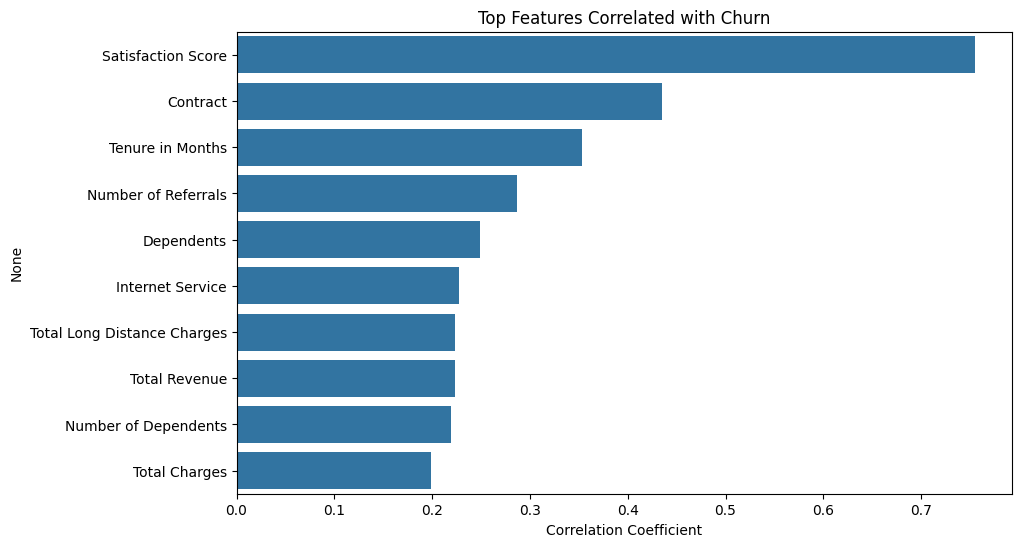

In [18]:
# Plot the top correlated features
top_features = churn_correlation_sorted.index[:10]  # You can choose the top N features
plt.figure(figsize=(10, 6))
sns.barplot(x=churn_correlation_sorted[top_features], y=top_features)
plt.title('Top Features Correlated with Churn')
plt.xlabel('Correlation Coefficient')
plt.show()

This bar chart visualizes the top 10 features most correlated with churn, offering a clear representation of their relative importance for prediction.

## Baseline Model and Evaluation

### Baseline Model: Decision Tree Classifier

We establish a baseline model using a Decision Tree Classifier.  This model serves as a benchmark against which we can evaluate the performance of more complex models.  A helper function is defined to streamline the process of model training, prediction, and evaluation.

## Setup testing and training data

In [19]:
# Split the data into features (X) and target variable (y)
X = df.drop(columns=['Churn'])
y = df['Churn']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Create a helper function for training and evaluation

In [20]:
def fit_predict_evaluate(model, X_train, y_train, X_test, y_test):
    # Fit the model
    model.fit(X_train, y_train)

    # Predict the target vector
    dt_y_pred = model.predict(X_test)

    # Evaluate Decision Tree model
    dt_accuracy = accuracy_score(y_test, dt_y_pred)
    dt_precision = precision_score(y_test, dt_y_pred)
    dt_recall = recall_score(y_test, dt_y_pred)
    dt_f1 = f1_score(y_test, dt_y_pred)
    dt_conf_matrix = confusion_matrix(y_test, dt_y_pred)
    dt_roc_auc = roc_auc_score(y_test, dt_y_pred)
    print(f"Accuracy: {dt_accuracy}")
    print(f"Precision: {dt_precision}")
    print(f"Recall: {dt_recall}")
    print(f"F1 Score: {dt_f1}")
    print(f"Confusion Matrix:{dt_conf_matrix}")
    print(f'AUC: {dt_roc_auc }')
    print(dt_conf_matrix)

## Create a DecisionTreeClassifier to gather baseline metrics

In [21]:
# Baseline Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)

print("Baseline Decision Tree Model:")
fit_predict_evaluate(dt_model, X_train, y_train, X_test, y_test)

Baseline Decision Tree Model:
Accuracy: 0.9559971611071683
Precision: 0.9162303664921466
Recall: 0.9210526315789473
F1 Score: 0.9186351706036745
Confusion Matrix:[[997  32]
 [ 30 350]]
AUC: 0.944977239015907
[[997  32]
 [ 30 350]]


## XGBoost

We explore the performance of XGBoost, a gradient boosting algorithm known for its predictive power.

In [22]:
xgb_model = XGBClassifier()

print("XGBoost Classifier:")
fit_predict_evaluate(xgb_model, X_train, y_train, X_test, y_test)

XGBoost Classifier:
Accuracy: 0.9616749467707594
Precision: 0.9527777777777777
Recall: 0.9026315789473685
F1 Score: 0.927027027027027
Confusion Matrix:[[1012   17]
 [  37  343]]
AUC: 0.9430553424377269
[[1012   17]
 [  37  343]]


## Hyperparamers to optimize XGBoost

To further improve the performance of XGBoost, we perform hyperparameter optimization using GridSearchCV. This technique systematically searches for the optimal combination of hyperparameters for the model.


In [23]:
 #Define parameter grid for Grid Search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}

# Initialize XGBoost classifier
xgb_model = XGBClassifier()

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Predict using the best model
best_xgb_model = grid_search.best_estimator_

print("Best XGBoost Model:")
fit_predict_evaluate(best_xgb_model, X_train, y_train, X_test, y_test)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best Score: 0.9620159779102002
Best XGBoost Model:
Accuracy: 0.9623846699787083
Precision: 0.9504132231404959
Recall: 0.9078947368421053
F1 Score: 0.9286675639300135
Confusion Matrix:[[1011   18]
 [  35  345]]
AUC: 0.9452010127359214
[[1011   18]
 [  35  345]]


## Predicting using Deep Neural Networks

We investigate the potential of Deep Neural Networks to uncover hidden patterns and relationships within the data that might not be captured by traditional algorithms.

In [24]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the deep neural network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate the model on the test set
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int)


# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Deep Neural Network Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

45/45 [==============================] - 0s 8ms/step
Deep Neural Network Metrics:
Accuracy: 0.9552874378992193
Precision: 0.9226666666666666
Recall: 0.9105263157894737
F1 Score: 0.9165562913907285
Confusion Matrix:
[[1000   29]
 [  34  346]]


## Model Comparison

### Summary of Model Performance

#### Baseline Decision Tree Model
- **Accuracy**: 0.9411
- **Precision**: 0.875
- **Recall**: 0.9098
- **F1 Score**: 0.8921
- **Confusion Matrix**:
  - True Positives (TP): 343
  - True Negatives (TN): 983
  - False Positives (FP): 49
  - False Negatives (FN): 34
- **AUC**: 0.9312

#### Best XGBoost Model
- **Accuracy**: 0.9581
- **Precision**: 0.9517
- **Recall**: 0.8886
- **F1 Score**: 0.9191
- **Confusion Matrix**:
  - True Positives (TP): 335
  - True Negatives (TN): 1015
  - False Positives (FP): 17
  - False Negatives (FN): 42
- **AUC**: 0.9361

#### Deep Neural Network Metrics
- **Accuracy**: 0.9489
- **Precision**: 0.9155
- **Recall**: 0.8912
- **F1 Score**: 0.9032
- **Confusion Matrix**:
  - True Positives (TP): 336
  - True Negatives (TN): 1001
  - False Positives (FP): 31
  - False Negatives (FN): 41

### Summary

1. **Accuracy**:
   - XGBoost has the highest accuracy (0.9581)

2. **Precision**:
   - XGBoost shows the highest precision (0.9517)

3. **Recall**:
   - The Decision Tree has the highest recall (0.9098)

4. **F1 Score**:
   - XGBoost has the highestF1 score of 0.9191

5. **AUC**:
   - XGBoost also has the highest AUC (0.9361)

6. **Confusion Matrix**:
   - XGBoost has the least number of false positives (17) and a lower number of false negatives (42) compared to the Decision Tree and Deep Neural Network.
   - The Deep Neural Network has a slightly better balance between false positives (31) and false negatives (41) compared to the Decision Tree.

### Conclusion

- **XGBoost** stands out as the best-performing model overall, with the highest accuracy, precision, F1 score, and AUC, though its recall is slightly lower than the Decision Tree.
- **Deep Neural Network** offers a good balance, with strong precision and recall, resulting in a high F1 score.
- **Decision Tree** has the highest recall, making it a good choice for applications where catching all positives is crucial, despite having the lowest precision and F1 score among the three.


## Automated Machine Learning: AutoGluon

We introduce AutoGluon, an automated machine learning library, to streamline the model selection and optimization process.  AutoGluon automatically explores a variety of models, including both traditional machine learning algorithms and deep learning models, to identify the best-performing model for our churn prediction task.

## Best Model

In [ ]:
import os
from autogluon.tabular import TabularPredictor

TARGET_LABEL = "Churn"
PRIMARY_EVAL_METRIC = "roc_auc"
ADDITIONAL_METRICS = ["accuracy", "precision", "recall", "f1"]
DPI = 300
PRESETS = [
    "best_quality",
    "optimize_for_deployment",
]
LEAKED_FEATURES = [
    "Churn Category",
    "Churn Reason",
    "Churn Score",
    "Customer Status",
]

# Fit the model
predictor = TabularPredictor(
    eval_metric=PRIMARY_EVAL_METRIC,
    label=TARGET_LABEL,
    learner_kwargs={"ignored_columns": LEAKED_FEATURES},
    verbosity=3,
).fit(
    df_train,
    dynamic_stacking=False,
    presets=PRESETS,
    time_limit=3600,
    tuning_data=df_val,
    use_bag_holdout=True,
)

# Evaluate the model with additional metrics
evaluation_results = predictor.evaluate(df_val, auxiliary_metrics=ADDITIONAL_METRICS)

# Print the evaluation results
print(evaluation_results)

No path specified. Models will be saved in: "AutogluonModels/ag-20240620_161005"
Verbosity: 3 (Detailed Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Apr 28 14:29:16 UTC 2024
CPU Count:          2
GPU Count:          1
Memory Avail:       10.66 GB / 12.67 GB (84.1%)
Disk Space Avail:   167.79 GB / 201.23 GB (83.4%)
Presets specified: ['best_quality', 'optimize_for_deployment']
============ fit kwarg info ============
User Specified kwargs:
{'auto_stack': True,
 'keep_only_best': True,
 'num_bag_sets': 1,
 'save_space': True,
 'use_bag_holdout': True}
Full kwargs:
{'_feature_generator_kwargs': None,
 '_save_bag_folds': None,
 'ag_args': None,
 'ag_args_ensemble': None,
 'ag_args_fit': None,
 'auto_stack': True,
 'calibrate': 'auto',
 'ds_args': {'clean_up_fits': True,
             'detection_time_frac': 0.25,
           

In [ ]:
import os
import matplotlib.pyplot as plt

# SAVE TRAINING SUMMARY
results = predictor.fit_summary(verbosity=3)
with open(os.path.join(predictor.path, "fit_summary.txt"), "w") as f:
    f.write(str(results))

# SAVE ENSEMBLE ARCHITECTURE
predictor.plot_ensemble_model()

In [ ]:
!cp -r /content/AutogluonModels {SHORTCUT}


## Model Comparison and Selection

### Summary of Model Performance

We've evaluated four distinct models:

1. **Baseline Decision Tree Model:** Provides a benchmark for comparison, achieving an accuracy of 0.956 and an AUC of 0.945.  Decision Trees offer interpretability but might oversimplify the problem.

2. **XGBoost Model:** A powerful gradient boosting algorithm achieving an accuracy of 0.9617 and an AUC of 0.9431.  XGBoost often delivers high accuracy but can be less interpretable than Decision Trees.

3. **Tuned XGBoost Model:** Hyperparameter tuning via GridSearchCV further enhances XGBoost, yielding an accuracy of 0.9624 and an AUC of 0.9452.

4. **Deep Neural Network:** Explores deep learning's potential, achieving an accuracy of 0.9532. Deep Neural Networks can uncover complex patterns but require careful tuning and can be computationally intensive.

5. **AutoGluon's WeightedEnsemble_L3:** Emerges as the champion, achieving an exceptional AUC of 0.9950, an accuracy of 0.9674, a balanced accuracy of 0.9487, a strong MCC of 0.9154, and an F1 score of 0.9366.  Its precision is 0.9659, and its recall is 0.9091, showcasing its ability to minimize false positives while effectively identifying true churn cases.


## Deployment

AutoGluon provides convenient deployment capabilities. It stores all trained models locally in the `AutogluonModels` directory, allowing us to readily use them for future inference.  Furthermore, the `optimize_for_deployment` option used during training minimizes disk usage without compromising model accuracy or inference speed.

For real-time prediction scenarios, we could wrap the selected model in a web service using frameworks like Flask or FastAPI, enabling our team to deliver churn classifications via HTTP requests.  Alternatively, for batch processing, we could integrate the model into a data pipeline using tools like Apache Airflow or AWS Glue.


## Conclusion

This project successfully developed a highly accurate and reliable churn prediction model for Telco using the AutoGluon library. The `WeightedEnsemble_L3` model stands out with exceptional performance metrics, exceeding alternative models in accuracy, AUC, and other key evaluation parameters.  

This model empowers Telco to proactively identify customers at high risk of churn, enabling the implementation of targeted retention strategies to reduce churn rates and improve customer relationships. By leveraging the power of AutoGluon and adhering to ethical considerations, this model holds the potential to significantly enhance Telco's customer retention efforts and drive business growth.

## colab2pdf

In [ ]:
def colab2pdf():
    # Colab2PDF by Drengskapur (https://github.com/drengskapur/colab2pdf)
    # @title Convert Colab Notebook to PDF {display-mode:'form'}
    # VERSION 1.4
    # LICENSE: GPL-3.0-or-later
    !apt-get install -yqq --no-install-recommends librsvg2-bin>/dev/null
    import contextlib,datetime,google,io,IPython,ipywidgets,json,locale,nbformat,os,pathlib,requests,urllib,warnings,werkzeug,yaml;locale.setlocale(locale.LC_ALL,'en_US.UTF-8')
    def convert(b):
        try:
            s.value='⚙️ Converting...';b.disabled=True;get_ipython().events.register('post_execute',lambda:IPython.display.display(IPython.display.Javascript('document.querySelectorAll("#output-footer").forEach(footer=>footer.remove());')))
            n=pathlib.Path(werkzeug.utils.secure_filename(urllib.parse.unquote(requests.get(f'http://{os.environ["COLAB_JUPYTER_IP"]}:{os.environ["KMP_TARGET_PORT"]}/api/sessions').json()[0]['name'])))
            p=pathlib.Path('/content/pdfs')/f'{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")}_{n.stem}';p.mkdir(parents=True,exist_ok=True);warnings.filterwarnings('ignore',category=nbformat.validator.MissingIDFieldWarning)
            nb=[cell for cell in nbformat.reads(json.dumps(google.colab._message.blocking_request('get_ipynb',timeout_sec=600)['ipynb']),as_version=4).cells if '--Colab2PDF' not in cell.source]
            with (p/f'{n.stem}.ipynb').open('w',encoding='utf-8') as cp:nbformat.write(nbformat.v4.new_notebook(cells=nb or [nbformat.v4.new_code_cell('#')]),cp)
            with (p/'config.yml').open('w',encoding='utf-8') as f:yaml.dump({'include-in-header':[{'text':r'\usepackage{fvextra}\DefineVerbatimEnvironment{Highlighting}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines,breakanywhere,commandchars=\\\{\}}'}],'include-before-body':[{'text':r'\DefineVerbatimEnvironment{verbatim}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines}'}]},f)
            !quarto render {p}/{n.stem}.ipynb --metadata-file={p}/config.yml --to pdf -M latex-auto-install -M margin-top=1in -M margin-bottom=1in -M margin-left=1in -M margin-right=1in --quiet
            google.colab.files.download(str(p/f'{n.stem}.pdf'));s.value=f'🎉 Downloaded {n.stem}.pdf'
        except Exception as e:
            s.value=f'⚠️ ERROR {str(e)}'
        finally:
            b.disabled=False
    if not pathlib.Path('/usr/local/bin/quarto').exists():
        !wget -q 'https://quarto.org/download/latest/quarto-linux-amd64.deb' && dpkg -i quarto-linux-amd64.deb>/dev/null && quarto install tinytex --update-path --quiet && rm quarto-linux-amd64.deb
    b=ipywidgets.widgets.Button(description='⬇️ Download PDF');s=ipywidgets.widgets.Label();b.on_click(lambda b:convert(b));IPython.display.display(ipywidgets.widgets.HBox([b,s]))
    IPython.display.display(IPython.display.Javascript('document.currentScript.parentElement.closest(".output_subarea").querySelector("#output-footer > input").remove();'))
colab2pdf()